Note: this code is illustrative; it won't run without the raw gaze data, which is too big to upload. The code and figures show how Figure 4A in the paper was generated.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, glob, json, re
import pygaze
# import GazeParser
from helpers import *
from tqdm import tqdm

In [ ]:
import helpers

In [ ]:
sys.path.append('pygazeanalyser')

In [ ]:
import gazeplotter, opengazereader, idfreader, eyetribereader, edfreader, detectors, traces

In [5]:
from gazeplotter import parse_fixations, gaussian

In [6]:
# Read gaze data from server mounted to Finder
proj_dir = '/Volumes/jvanbaar/projects/SOC_STRUCT_LEARN'
data_dir = '/Volumes/jvanbaar/data/jvanbaar/SOC_STRUCT_LEARN'

In [7]:
proj_dir

'/Volumes/jvanbaar/projects/SOC_STRUCT_LEARN'

## Load fixations

In [8]:
ROI_radius = 100
all_fix = pd.read_csv(proj_dir +
               '/Data/Cleaned/all_fixations_tagged_ROI_radius-%i.csv'%ROI_radius,
                     index_col = 0)
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,False,True,False,False,False,False
2,158471.0,546.94,166.93,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
3,125121.0,595.40,9.29,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
4,158525.0,703.15,112.04,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False


##### Limit to payoff matrix

In [9]:
all_fix = all_fix.loc[(all_fix['x'] >= 200) & (all_fix['x'] <= 1120) &
                      (all_fix['y'] >= 200) & (all_fix['y'] <= 950),:].reset_index(drop=True)

In [10]:
all_fix.head()

,dur,x,y,sub,trial,eye,block,player_type,10_1,10_2,S_1,T_1,T_2,S_2,5_1,5_2
0,183522.0,719.21,453.20,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
1,100111.0,1015.32,356.12,5,1,L,1.0,opt_nat,False,False,False,True,False,False,False,False
2,183510.0,707.59,320.82,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False
3,150135.0,801.86,404.91,5,1,L,1.0,opt_nat,False,False,True,False,False,False,False,False
4,158498.0,703.38,524.64,5,1,L,1.0,opt_nat,False,False,False,False,False,False,False,False


In [11]:
all_fix.shape

(325795, 16)

## Create heatmaps

Ran this part on Oscar using run_sub_pt_heatmap.py. Stored 1 mean heatmap per subject and player type.

## Load & average heatmaps

In [12]:
mean_heatmaps = dict()
dispsize = [1680, 1050]
subs = np.arange(5,55)

In [13]:
pts = ['opt_nat','pess_nat','opt_inv','pess_inv']

In [14]:
for pt in pts:
    mean_heatmaps[pt] = np.zeros([dispsize[1],dispsize[0]])
    for sub in tqdm(subs):
        mean_heatmaps[pt] += pd.read_csv(data_dir +
            '/Gaze/Results/sub_pt_heatmaps/sub-%03d_pt-%s_mean_heatmap.csv'%(sub,pt), index_col = 0).values
    mean_heatmaps[pt] = mean_heatmaps[pt] / len(subs)

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


opt_nat


/Applications/anaconda3/envs/structLearn/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/envs/structLearn/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Volumes/jvanbaar/projects/SOC_STRUCT_LEARN/gaze_analysis/helpers.py:481: RuntimeWarning: invalid value encountered in less
  hm_tmp[hm_tmp<lowbound] = np.NaN


pess_nat
opt_inv
pess_inv


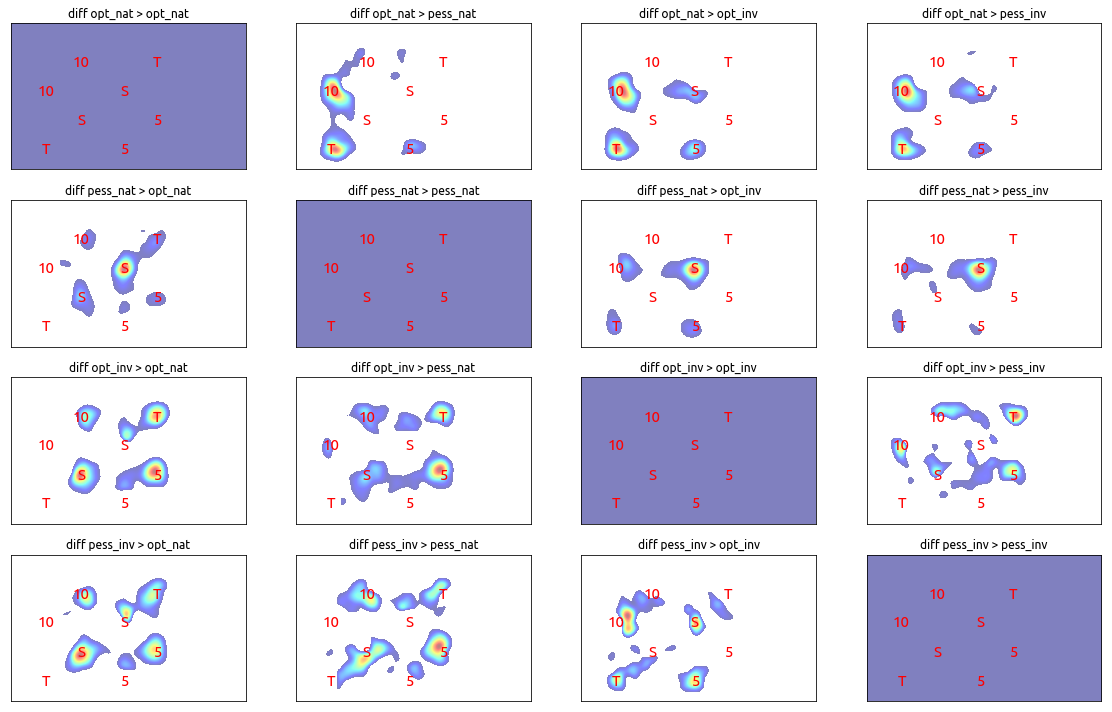

In [35]:
fig,ax = plt.subplots(len(pts),len(pts),figsize = [16,10])
# number_locations = get_number_locations()
for pt1i, pt1 in enumerate(pts):
    print(pt1)
    for pt2i, pt2 in enumerate(pts):
        diff = mean_heatmaps[pt1] - mean_heatmaps[pt2]
        plot_heatmap(diff, dispsize, draw_numbers=True, alpha = .5, ax = ax[pt1i,pt2i])
#         ax[pt1i,pt2i].imshow(np.flipud(diffs[pt1i,pt2i])*1e6, cmap = 'jet',zorder = 1)
#         for ri, row in number_locations.iterrows():
#             ax[pt1i,pt2i].text(row['X'],dispsize[1] - row['Y'],row['num'],zorder = 2,
#                fontdict = {'fontsize':15, 'verticalalignment':'center','horizontalalignment':'center', 'color':'r'})
        ax[pt1i,pt2i].set(xlim = [0,1680], ylim = [0,1050], title = 'diff %s > %s'%(pt1,pt2),
              xticks = [], yticks = [])
plt.tight_layout()

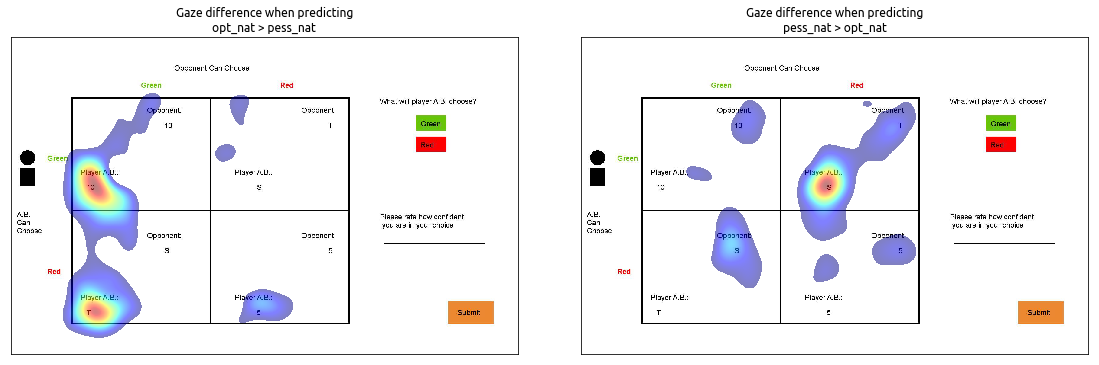

In [15]:
fig, ax = plt.subplots(1,2,figsize=[16,5], sharey=True)
game_screen = image.imread('Game_screen.jpg')

for ai,up_low in enumerate([['opt_nat','pess_nat'],['pess_nat','opt_nat']]):
    up,low = up_low
    diff = mean_heatmaps[up] - mean_heatmaps[low]
    ax[ai].imshow(np.flipud(game_screen))
    plot_heatmap(diff, dispsize, draw_numbers=False, alpha = .5, ax = ax[ai])
    ax[ai].set(title = 'Gaze difference when predicting\n%s > %s'%(up,low))

ax[0].invert_yaxis()
plt.tight_layout()
# plt.savefig(base_dir + '/gaze_analysis/Results/heatmap_diffs/Gaze_diff_opt_pess.pdf',
#             bbox_inches='tight', transparent = True, dpi = 400)

## Try to plot bidirectional heatmap (hot-cold)

In [15]:
def plot_heatmap_bidir(heatmap, dispsize, ax = None, alpha = .5, remove_zeros = True,
                    draw_numbers = False, num_fontsize = 30, 
                       S = None, T = None, vmax = None, vmin = None,
                      cmap = 'coolwarm', zero_threshold = 1):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=[8,5])
        ax.set(xlim = [0,1680], ylim = [0,1050], aspect = 1)
    
    # Plot heatmap
    hmdat = heatmap.copy()
    if remove_zeros:
        posmean = np.mean(hmdat[hmdat>0]) # Remove points with below-mean 'heat'
        negmean = np.mean(hmdat[hmdat<0]) # Remove points with below-mean 'heat'
        hmdat[(hmdat<(posmean*zero_threshold)) & (hmdat>(negmean*zero_threshold))] = np.NaN
    hmap = ax.imshow(np.flipud(hmdat), cmap = cmap, alpha=alpha, zorder = 2,
                    vmin = vmin, vmax = vmax)
    
    ax.set(xticks = [], yticks = [])     
        
    if draw_numbers:
        number_locations = get_number_locations()
#         print(number_locations)
        if S is not None:
            number_locations.loc[number_locations['num']=='S','num'] = S
        if T is not None:
            number_locations.loc[number_locations['num']=='T','num'] = T
        for ri, row in number_locations.iterrows():
            ax.text(row['X'],dispsize[1] - row['Y'],row['num'],
                    fontdict = {'fontsize':num_fontsize,
                'verticalalignment':'center','horizontalalignment':'center',
                'color':'k'}, zorder = 2)
    
    return ax,hmdat,hmap

In [41]:
from matplotlib.colors import LinearSegmentedColormap
colors = [sns.color_palette('tab10',2)[0],
         [1,1,1],
         sns.color_palette('tab10',2)[1]]
cm = LinearSegmentedColormap.from_list(
        'BuOr', colors, N=1024)
colors_alpha = []
for ci,colortuple in enumerate(colors):
    ap = list(colortuple).copy()
    ap.append(0) if ci == 1 else ap.append(1)
    colors_alpha.append(ap)
cm_a = LinearSegmentedColormap.from_list(
        'BuOr', colors_alpha, N=1024)

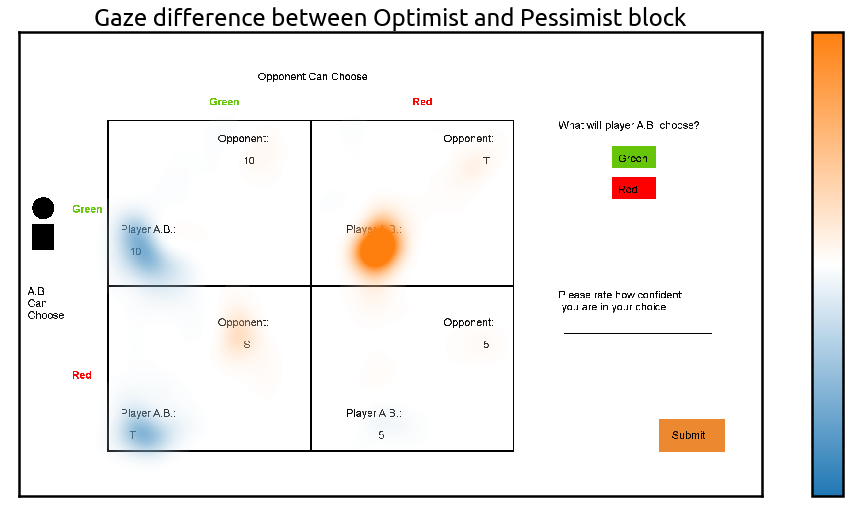

In [61]:
sns.set_context('poster')
fig, ax = plt.subplots(1,2,figsize=[12.5,7.5], gridspec_kw={'width_ratios':[12,.5]})
game_screen = image.imread('Game_screen.png')
ax[0].imshow(np.flipud(game_screen))

diff = mean_heatmaps['pess_nat'] - mean_heatmaps['opt_nat']
lim = 1e-8
axout,hmdat,hmap = plot_heatmap_bidir(diff, dispsize, draw_numbers=False,
                                  alpha = 1, ax = ax[0],
                                  cmap = cm_a, vmin = -lim, vmax = lim,
                                      remove_zeros = True, zero_threshold = 1,
                                     )
ax[0].invert_yaxis()
ax[0].set(title = 'Gaze difference between Optimist and Pessimist block')
cbar = plt.colorbar(mappable=hmap, cax=ax[1])
cbar.set_ticks([])
plt.tight_layout()

In [62]:
fig.savefig(data_dir + '/Gaze/Results/heatmap_diffs/Gaze_diff_pess-opt_bidirect_BuOr_cbar.png',
            bbox_inches='tight', transparent = True, dpi = 500)

[Text(0.5, 1.0, 'Gaze difference between Optimist and Pessimist block')]

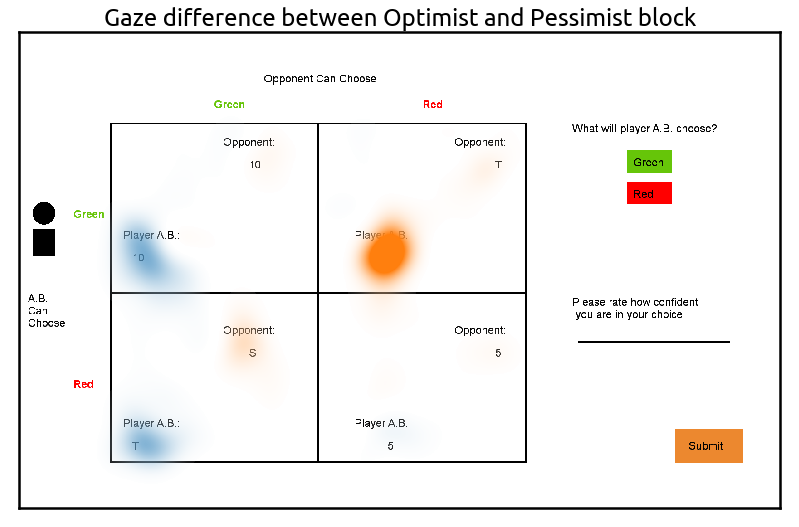

In [63]:
sns.set_context('poster')
fig, ax = plt.subplots(1,1,figsize=[14,8.75])
game_screen = image.imread('Game_screen.png')
ax.imshow(np.flipud(game_screen))

diff = mean_heatmaps['pess_nat'] - mean_heatmaps['opt_nat']
lim = 1e-8
axout,hmdat,hmap = plot_heatmap_bidir(diff, dispsize, draw_numbers=False,
                                  alpha = 1, ax = ax,
                                  cmap = cm_a, vmin = -lim, vmax = lim,
                                      remove_zeros = True, zero_threshold = 1,
                                     )
ax.invert_yaxis()
ax.set(title = 'Gaze difference between Optimist and Pessimist block')
# cbar = plt.colorbar(mappable=hmap, cax=ax[1])
# cbar.set_ticks([])
# plt.tight_layout()

In [64]:
fig.savefig(data_dir + '/Gaze/Results/heatmap_diffs/Gaze_diff_pess-opt_bidirect_BuOr.png',
            bbox_inches='tight', transparent = True, dpi = 500)

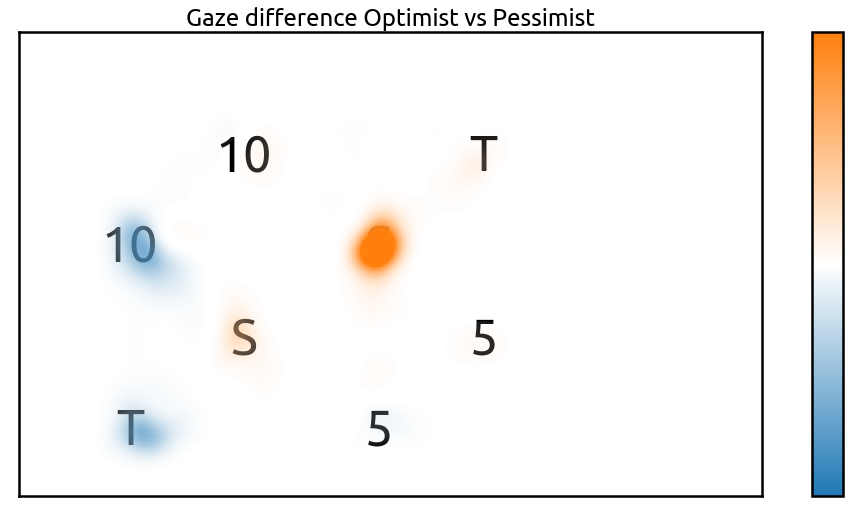

In [59]:
sns.set_context('poster')
fig, ax = plt.subplots(1,2,figsize=[12.5,7.5], gridspec_kw={'width_ratios':[12,.5]})

diff = mean_heatmaps['pess_nat'] - mean_heatmaps['opt_nat']
lim = 1e-8
axout,hmdat,hmap = plot_heatmap_bidir(diff, dispsize, draw_numbers = True,
                                  alpha = 1, ax = ax[0], num_fontsize = 50,
                                  cmap = cm_a, vmin = -lim, vmax = lim,
                                      remove_zeros = True, zero_threshold = 1,
                                     )
ax[0].invert_yaxis()
ax[0].set(title = 'Gaze difference Optimist vs Pessimist')
cbar = plt.colorbar(mappable=hmap, cax=ax[1])
cbar.set_ticks([])
plt.tight_layout()

## Contrast subjects by motives in model

In [12]:
base_dir = '/Volumes/jvanbaar/projects/SOC_STRUCT_LEARN'
bestPerSubject_features = pd.read_csv(base_dir + '/Data/Cleaned/ModelFeaturesPerSubject.csv',index_col = 0)
bestPerSubject_features['sub'] = bestPerSubject_features['subID'] - 5000
bestPerSubject_features.head()
# sub_fix = sub_fix.merge(bestPerSubject_features, on = 'sub')
# sub_fix.head()

,subID,Coop,Greed,Risk,Regret,comb,comb_labels,sub
0,5005,True,True,True,False,1110,"Coop.,\nGreed,\nRisk",5
1,5006,True,True,True,False,1110,"Coop.,\nGreed,\nRisk",6
2,5007,False,True,True,False,110,"Greed,\nRisk",7
3,5008,False,True,True,False,110,"Greed,\nRisk",8
4,5009,False,True,True,False,110,"Greed,\nRisk",9


In [13]:
bestPerSubject_features.loc[bestPerSubject_features['Risk'],'sub'].unique()

array([ 5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 22, 24, 26,
       27, 28, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 52, 54])

In [16]:
mean_heatmaps_motive = dict()
dispsize = [1680, 1050]
subs = np.arange(5,55)

In [40]:
for risk_included in [False,True]:
    group_label = 'risk_%s'%risk_included
    mean_heatmaps_motive[group_label] = dict()
    subs = bestPerSubject_features.loc[bestPerSubject_features['Risk'] == risk_included,'sub'].unique()
    for pt in pts:
        print(pt)
        mean_heatmaps_motive[group_label][pt] = np.zeros([dispsize[1],dispsize[0]])
        for sub in tqdm(subs):
            mean_heatmaps_motive[group_label][pt] += pd.read_csv(base_dir +
                '/gaze_analysis/Results/sub_pt_heatmaps/sub-%03d_pt-%s_mean_heatmap.csv'%(sub,pt), index_col = 0).values
        mean_heatmaps_motive[group_label][pt] = mean_heatmaps_motive[group_label][pt] / len(subs)

  0%|          | 0/10 [00:00<?, ?it/s]

opt_nat


  0%|          | 0/10 [00:00<?, ?it/s]

pess_nat


  0%|          | 0/10 [00:00<?, ?it/s]

opt_inv


  0%|          | 0/10 [00:00<?, ?it/s]

pess_inv


  0%|          | 0/40 [00:00<?, ?it/s]

opt_nat


  0%|          | 0/40 [00:00<?, ?it/s]

pess_nat


  0%|          | 0/40 [00:00<?, ?it/s]

opt_inv


  0%|          | 0/40 [00:00<?, ?it/s]

pess_inv


100%|██████████| 40/40 [00:26<00:00,  1.51it/s]


False
True


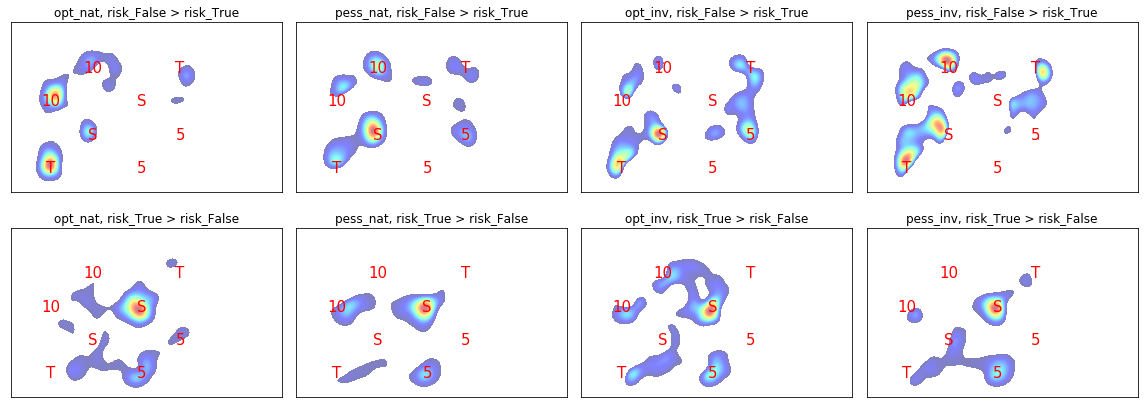

In [51]:
fig,ax = plt.subplots(2,len(pts),figsize = [16,6])
# number_locations = get_number_locations()
for ri, risk_included in enumerate([False,True]):
    print(risk_included)
    group_label = 'risk_%s'%risk_included
    op = not risk_included
    op_label = 'risk_%s'%op
    for pti, pt in enumerate(pts):
#         diff = mean_heatmaps[pt1] - mean_heatmaps[pt2]
        diff = mean_heatmaps_motive[group_label][pt] - mean_heatmaps_motive[op_label][pt]
        plot_heatmap(diff, dispsize, draw_numbers=True, alpha = .5, ax = ax[ri, pti])
#         ax[pt1i,pt2i].imshow(np.flipud(diffs[pt1i,pt2i])*1e6, cmap = 'jet',zorder = 1)
#         for ri, row in number_locations.iterrows():
#             ax[pt1i,pt2i].text(row['X'],dispsize[1] - row['Y'],row['num'],zorder = 2,
#                fontdict = {'fontsize':15, 'verticalalignment':'center','horizontalalignment':'center', 'color':'r'})
        ax[ri, pti].set(xlim = [0,1680], ylim = [0,1050], title = '%s, %s > %s'%(pt, group_label,op_label),
              xticks = [], yticks = [])
plt.tight_layout()

##### For predicting Optimist only:

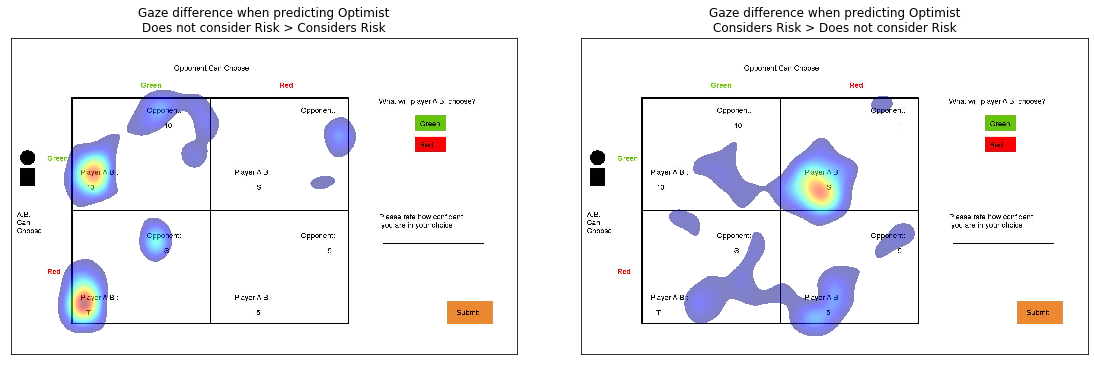

In [97]:
fig, ax = plt.subplots(1,2,figsize=[16,5], sharey=True)
game_screen = image.imread('Game_screen.jpg')
pt = 'opt_nat'
labels_full = {False:'Does not consider Risk', True:'Considers Risk'}
diffs = np.empty([2,dispsize[1],dispsize[0]])

for ai,up_low in enumerate([[False, True],[True, False]]):
    up,low = up_low
    up_label = 'risk_%s'%up
    low_label = 'risk_%s'%low
    diffs[ai] = mean_heatmaps_motive[up_label][pt] - mean_heatmaps_motive[low_label][pt]
    
vmax = np.max(diffs)
for ai,up_low in enumerate([[False, True],[True, False]]):
    up,low = up_low
    up_label = 'risk_%s'%up
    low_label = 'risk_%s'%low
    ax[ai].imshow(np.flipud(game_screen))
    helpers.plot_heatmap(diffs[ai], dispsize, draw_numbers=False, alpha = .5, ax = ax[ai], vmax = vmax)
    ax[ai].set(title = 'Gaze difference when predicting Optimist\n%s > %s'%(labels_full[up],labels_full[low]))

ax[0].invert_yaxis()
plt.tight_layout()
plt.savefig(base_dir + '/gaze_analysis/Results/heatmap_diffs/Gaze_diff_opt_risk-in-model.pdf',
            bbox_inches='tight', transparent = True, dpi = 400)

##### For predicting Pessimist only:

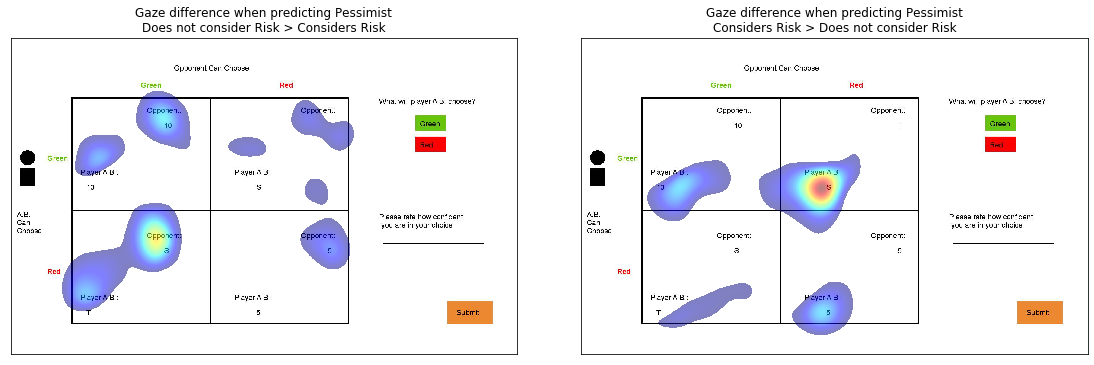

In [78]:
fig, ax = plt.subplots(1,2,figsize=[16,5], sharey=True)
game_screen = image.imread('Game_screen.jpg')
pt = 'pess_nat'
labels_full = {False:'Does not consider Risk', True:'Considers Risk'}

for ai,up_low in enumerate([[False, True],[True, False]]):
    up,low = up_low
    up_label = 'risk_%s'%up
    low_label = 'risk_%s'%low
    diff = mean_heatmaps_motive[up_label][pt] - mean_heatmaps_motive[low_label][pt]
    ax[ai].imshow(np.flipud(game_screen))
    helpers.plot_heatmap(diff, dispsize, draw_numbers=False, alpha = .5, ax = ax[ai], vmax = vmax)
    ax[ai].set(title = 'Gaze difference when predicting Pessimist\n%s > %s'%(labels_full[up],labels_full[low]))

ax[0].invert_yaxis()
plt.tight_layout()
plt.savefig(base_dir + '/gaze_analysis/Results/heatmap_diffs/Gaze_diff_pess_risk-in-model.pdf',
            bbox_inches='tight', transparent = True, dpi = 400)

##### For each group, contrast to Optimist

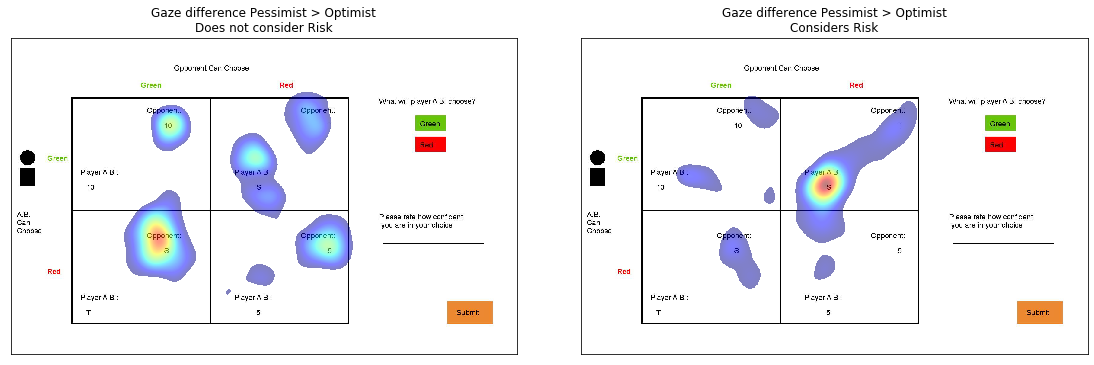

In [92]:
fig, ax = plt.subplots(1,2,figsize=[16,5], sharey=True)
game_screen = image.imread('Game_screen.jpg')
pt = 'pess_nat'
labels_full = {False:'Does not consider Risk', True:'Considers Risk'}
diffs = np.empty([2,dispsize[1],dispsize[0]])

up_label = 'pess_nat'
low_label = 'opt_nat'
for ai,risk_included in enumerate([False, True]):
    group_label = 'risk_%s'%risk_included
    diffs[ai] = mean_heatmaps_motive[group_label][up_label] - mean_heatmaps_motive[group_label][low_label]

vmax = np.max(np.max(diffs))
for ai,risk_included in enumerate([False, True]):
    ax[ai].imshow(np.flipud(game_screen))
    helpers.plot_heatmap(diffs[ai], dispsize, draw_numbers=False, alpha = .5, ax = ax[ai], vmax = vmax)
    ax[ai].set(title = 'Gaze difference Pessimist > Optimist\n%s'%(labels_full[risk_included]))

ax[0].invert_yaxis()
plt.tight_layout()
plt.savefig(base_dir + '/gaze_analysis/Results/heatmap_diffs/Gaze_diff_pess-opt_by-risk-in-model.pdf',
            bbox_inches='tight', transparent = True, dpi = 800)

##### Mean across all player types

In [17]:
pts = ['opt_nat','pess_nat','opt_inv','pess_inv']
for risk_included in [False,True]:
    group_label = 'risk_%s'%risk_included
    mean_heatmaps_motive[group_label] = np.zeros([dispsize[1],dispsize[0]])
    subs = bestPerSubject_features.loc[bestPerSubject_features['Risk'] == risk_included,'sub'].unique()
    for pt in pts:
#         print(pt)
#         mean_heatmaps_motive[group_label][pt] = np.zeros([dispsize[1],dispsize[0]])
        for sub in tqdm(subs):
            mean_heatmaps_motive[group_label] += pd.read_csv(base_dir +
                '/gaze_analysis/Results/sub_pt_heatmaps/sub-%03d_pt-%s_mean_heatmap.csv'%(sub,pt), index_col = 0).values
        mean_heatmaps_motive[group_label] = mean_heatmaps_motive[group_label] / (len(subs)*len(pts))

100%|██████████| 40/40 [25:59<00:00, 38.99s/it]


In [18]:
import pickle
with open('/Users/jvanbaar/Desktop/mean_heatmaps_motive.p', "wb" ) as file:
    pickle.dump(mean_heatmaps_motive, file)

In [19]:
mean_heatmaps_motive

{'risk_False': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'risk_True': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

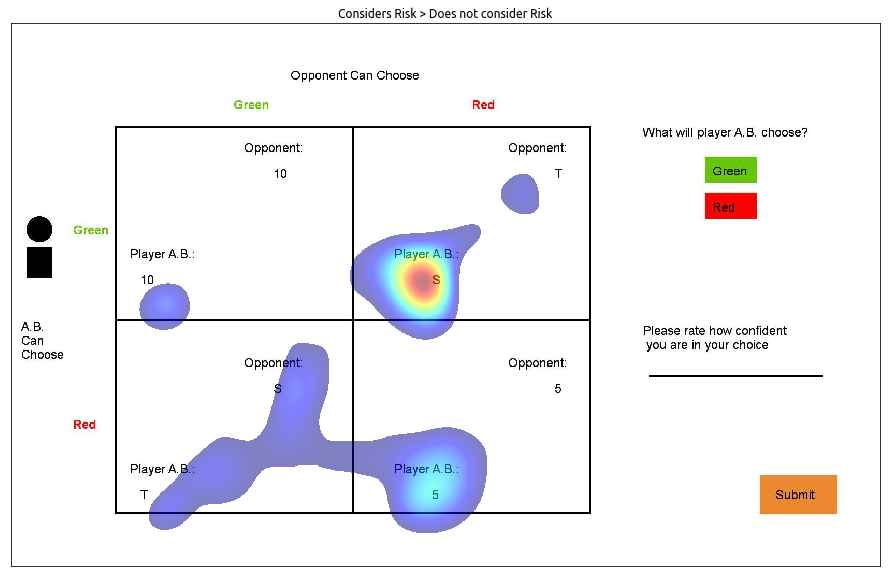

In [28]:
fig, ax = plt.subplots(1,1,figsize=[16,10], sharey=True)
game_screen = image.imread('/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Analysis_scripts/EyeTrackingAnalysis/Game_screen.jpg')
labels_full = {False:'Does not consider Risk', True:'Considers Risk'}
diffs = np.empty([2,dispsize[1],dispsize[0]])

up,low = [True,False]
up_label = 'risk_%s'%up
low_label = 'risk_%s'%low
diffs = mean_heatmaps_motive[up_label] - mean_heatmaps_motive[low_label]
    
vmax = np.max(diffs)
ax.imshow(np.flipud(game_screen))
helpers.plot_heatmap(diffs, dispsize, draw_numbers=False, alpha = .5, ax = ax, vmax = vmax)
ax.set(title = '%s > %s'%(labels_full[up],labels_full[low]))

ax.invert_yaxis()
# plt.tight_layout()
plt.savefig(base_dir + '/gaze_analysis/Results/heatmap_diffs/Gaze_diff_risk-in-model.pdf',
            bbox_inches='tight', transparent = True, dpi = 400)